# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

## **** Capstone Project ****

### Title: Multimodal Media Retrieval and Captioning System

Objective: Build a model capable of retrieving images and text based on cross-modal queries
and generating descriptive captions for images lacking textual information.





---



### Using CLIP from Scratch (code from Kaggle)
### on flickr8k dataset



---



# 1. Load Data Sets

## Using the dataset from Google Drive or from kaggle


In [1]:
#Data set source # google drive or kaggle

#data_source = "google_drive"
data_source = "kaggle"

# Date set
dataset = "flickr8k"
#dataset = "flickr30k"

#Dataset
dataset_name = "adityajn105/" + dataset   # dataset from kaggle


In [3]:
import os
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# root folder in the drive
Root_folder = "/content/drive/MyDrive/TalentSprint/Project/CP1"

if data_source == "google_drive":
  # Define path to Flickr8k images in Google Drive

  image_folder = Root_folder + "/" + dataset + "_dataset/Images"
  caption_file = Root_folder + "/" + dataset + "_dataset/captions.txt"
  output_file = Root_folder + "/" + dataset + "_clip_embeddings_gd.pt"
  csv_file = Root_folder + "/" + dataset + "_clip_retrieval_accuracy_gd.csv"

else:
  import kagglehub
  # Download latest version
  path = kagglehub.dataset_download(dataset_name,  force_download=True)
  print("Path to dataset files:", path)
  image_folder = "/kaggle/input/" + dataset + "/Images"
  caption_file = "/kaggle/input/" + dataset + "/captions.txt"

  output_dir = Root_folder + "/" + dataset + "_clip_scratch"  # or any path you need

  os.makedirs(output_dir, exist_ok=True)
  output_file = output_dir + "/" + dataset + "_clip_scratch_embeddings.pt"
  accuracy_csv_file = output_dir + "/" + dataset + "_clip_scratch_retrieval_accuracy.csv"
  captions_csv_file = output_dir + "/" + dataset + "_clip_scratch_captions.csv"


print(image_folder)
print(caption_file)
print(output_file)
print(accuracy_csv_file)
print(captions_csv_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to dataset files: /kaggle/input/flickr8k
/kaggle/input/flickr8k/Images
/kaggle/input/flickr8k/captions.txt
/content/drive/MyDrive/TalentSprint/Project/CP1/flickr8k_clip_scratch/flickr8k_clip_scratch_embeddings.pt
/content/drive/MyDrive/TalentSprint/Project/CP1/flickr8k_clip_scratch/flickr8k_clip_scratch_retrieval_accuracy.csv
/content/drive/MyDrive/TalentSprint/Project/CP1/flickr8k_clip_scratch/flickr8k_clip_scratch_captions.csv


In [3]:
!ls /kaggle/input/flickr8k/

captions.txt  Images


# Import Libraries

In [4]:
!pip install -q timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.1 MB/s eta 0:00:00


In [5]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

import time
import json

# 2. Some Pre-processing

In [6]:
import pandas as pd

# Read the text file.
# Use header=None because the file doesn't include column names.
# Specify names for the two columns: "image" and "caption".
# The file contains quoted captions where necessary.
df = pd.read_csv(caption_file,
                 header=None,
                 names=['image', 'caption'],
                 sep=',',
                 quotechar='"',
                 skiprows=1)


df['caption'] = df['caption'].str.lstrip()         # Remove any leading spaces from the caption.

# Generate a caption number for each image.
# This assigns 0, 1, 2, ... to each caption within the same image.
df['caption_number'] = df.groupby('image').cumcount()

# Generate a unique id for each image.
# This converts the image filename into a unique integer id.
df['id'] = df['image'].factorize()[0]

# (Optional) Reorder columns to keep the same structure as before.
df = df[['image', 'caption_number', 'caption', 'id']]

# Save the resulting DataFrame to a CSV file.
df.to_csv(captions_csv_file, index=False)
df.to_csv(output_dir + "/captions.csv", index=False)
# Display the first few rows.
print(df.head(10))


                       image  caption_number  \
0  1000268201_693b08cb0e.jpg               0   
1  1000268201_693b08cb0e.jpg               1   
2  1000268201_693b08cb0e.jpg               2   
3  1000268201_693b08cb0e.jpg               3   
4  1000268201_693b08cb0e.jpg               4   
5  1001773457_577c3a7d70.jpg               0   
6  1001773457_577c3a7d70.jpg               1   
7  1001773457_577c3a7d70.jpg               2   
8  1001773457_577c3a7d70.jpg               3   
9  1001773457_577c3a7d70.jpg               4   

                                             caption  id  
0  A child in a pink dress is climbing up a set o...   0  
1              A girl going into a wooden building .   0  
2   A little girl climbing into a wooden playhouse .   0  
3  A little girl climbing the stairs to her playh...   0  
4  A little girl in a pink dress going into a woo...   0  
5         A black dog and a spotted dog are fighting   1  
6  A black dog and a tri-colored dog playing with...   1  

# 3. CONFIG

In [7]:
class CFG:
    debug = False
    image_path = image_folder
    #captions_path = "."
    captions_path = output_dir
    output_dir = output_dir
    batch_size = 64
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1
cfg = CFG()

# 4. Utils

In [8]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

# 5. Dataset

In [9]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=cfg.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{cfg.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(cfg.size, cfg.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(cfg.size, cfg.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

# 6. Image & Text Encoders

In [10]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=cfg.model_name, pretrained=cfg.pretrained, trainable=cfg.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [11]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=cfg.text_encoder_model, pretrained=cfg.pretrained, trainable=cfg.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

# 7. Projection Head

In [12]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=cfg.projection_dim,
        dropout=cfg.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

# 8. CLIP

In [13]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=cfg.temperature,
        image_embedding=cfg.image_embedding,
        text_embedding=cfg.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

# 9. Train

In [14]:
# === Data Prep Functions ===
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{cfg.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not cfg.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

In [15]:
# === Training & Validation Functions ===
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(cfg.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(cfg.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [16]:
# === Main Training Script ===

# prepare data
train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

model = CLIPModel().to(CFG.device)

params = [
    {"params": model.image_encoder.parameters(), "lr": cfg.image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": cfg.text_encoder_lr},
    {"params": itertools.chain(
        model.image_projection.parameters(), model.text_projection.parameters()
    ), "lr": cfg.head_lr, "weight_decay": cfg.weight_decay}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=cfg.patience, factor=cfg.factor
)
step = "epoch"

train_losses = []    #added
valid_losses = []    #added
best_loss = float('inf')
start_time = time.time() # added

for epoch in range(cfg.epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model, valid_loader)

    train_losses.append(train_loss.avg)    #added
    valid_losses.append(valid_loss.avg)    #added

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(), output_file)
        print("Saved Best Model!")

    ### ADDED from Here  ######
    # Save checkpoint every epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss.avg,
        'valid_loss': valid_loss.avg
    }, f"{cfg.output_dir}/checkpoint_epoch_{epoch+1}.pt")

    ### ADDED till Here  ######

    lr_scheduler.step(valid_loss.avg)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

<ipython-input-9-30c6d3bfd76b>:40: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
<ipython-input-9-30c6d3bfd76b>:41: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-9-30c6d3bfd76b>:47: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
<ipython-input-9-30c6d3bfd76b>:48: UserWarning: Argum

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Saved Best Model!



🎯 Total training time: 17.24 minutes


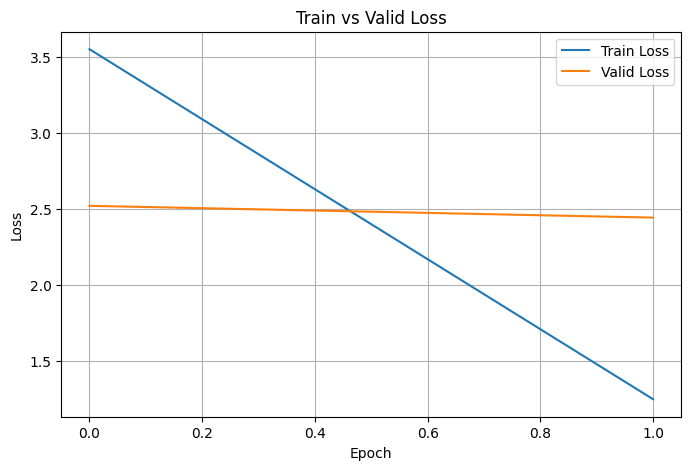

In [18]:
    #### ADDED from Here  ######
total_time = time.time() - start_time
print(f"\n🎯 Total training time: {total_time / 60:.2f} minutes")

# Save metadata
metadata = {
    "epochs": cfg.epochs,
    "batch_size": cfg.batch_size,
    "learning_rates": {
        "image_encoder_lr": cfg.image_encoder_lr,
        "text_encoder_lr": cfg.text_encoder_lr,
        "head_lr": cfg.head_lr
    },
    "train_losses": train_losses,
    "valid_losses": valid_losses,
    "total_training_time_minutes": total_time / 60
}

with open(f"{cfg.output_dir}/training_metadata.json", "w") as f:
  json.dump(metadata, f, indent=2)

# Plot and save loss curve
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Valid Loss")
plt.legend()
plt.grid()
plt.savefig(f"{cfg.output_dir}/loss_curve.png")

# 10. Inference

## Getting Image Embeddings

In [21]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(cfg.device)
    model.load_state_dict(torch.load(model_path, map_location=cfg.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(cfg.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [22]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, output_file)    # best.pt

<ipython-input-9-30c6d3bfd76b>:47: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
<ipython-input-9-30c6d3bfd76b>:48: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/127 [00:00<?, ?it/s]

## Finding Matches

In [23]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(cfg.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{cfg.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

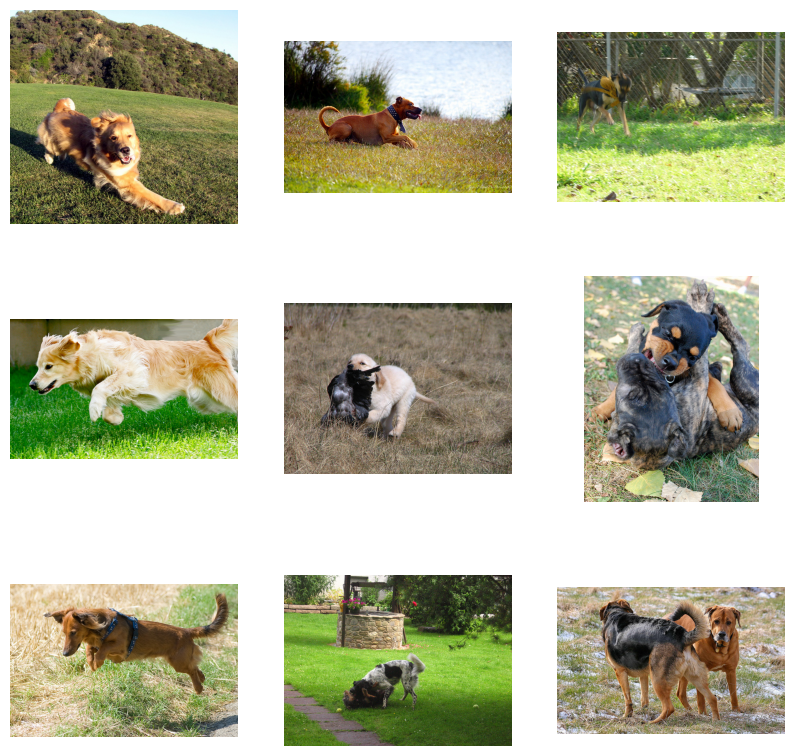

In [24]:
find_matches(model,
             image_embeddings,
             query="one dog sitting on the grass",
             image_filenames=valid_df['image'].values,
             n=9)

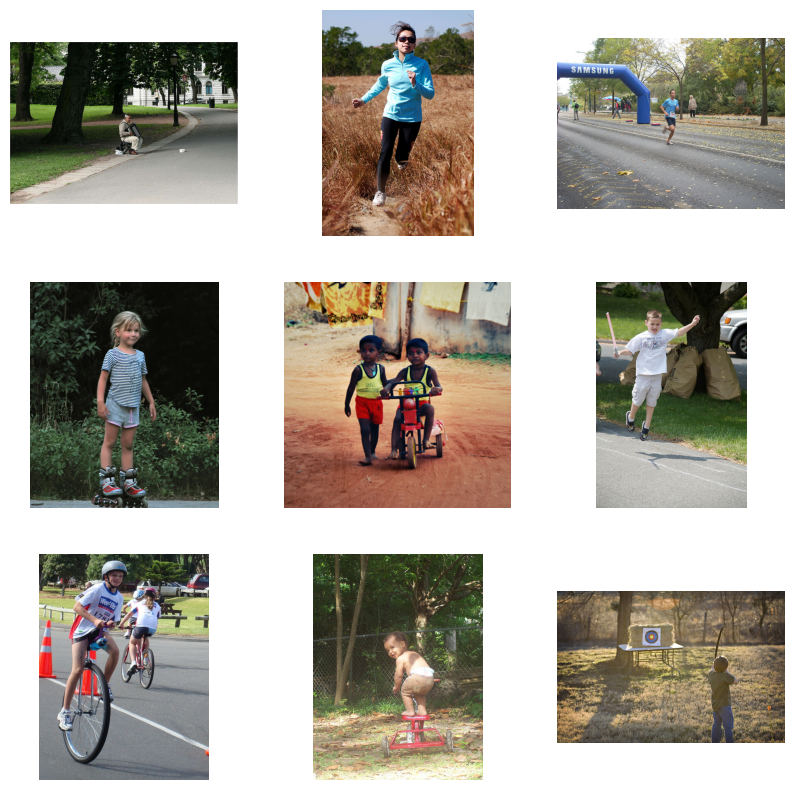

In [27]:
find_matches(model,
             image_embeddings,
             query="kid running on road",
             image_filenames=valid_df['image'].values,
             n=9)